In [32]:
import cv2 as cv
import numpy as np
from math import sqrt
from google.colab.patches import cv2_imshow
import os
import requests

In [33]:
#define constants
IMAGE_NAMES = ["before.jpg", "after.jpg","after2.jpg","after3.jpg","after4.jpg","after5.jpg","after6.jpg"]
urls = ["http://www.columbia.edu/~km3533/before.jpg",
        "http://www.columbia.edu/~km3533/after.jpg","http://www.columbia.edu/~wsh2117/after2.jpg","http://www.columbia.edu/~wsh2117/after3.jpg","http://www.columbia.edu/~wsh2117/after4.jpg","http://www.columbia.edu/~wsh2117/after5.jpg","http://www.columbia.edu/~wsh2117/after9.jpg"]

In [34]:
#@title Download the images
for i, url in zip(range(len(urls)), urls):
  with open(IMAGE_NAMES[i], "wb") as pipes_image:
    pipes_image.write(requests.get(url).content)

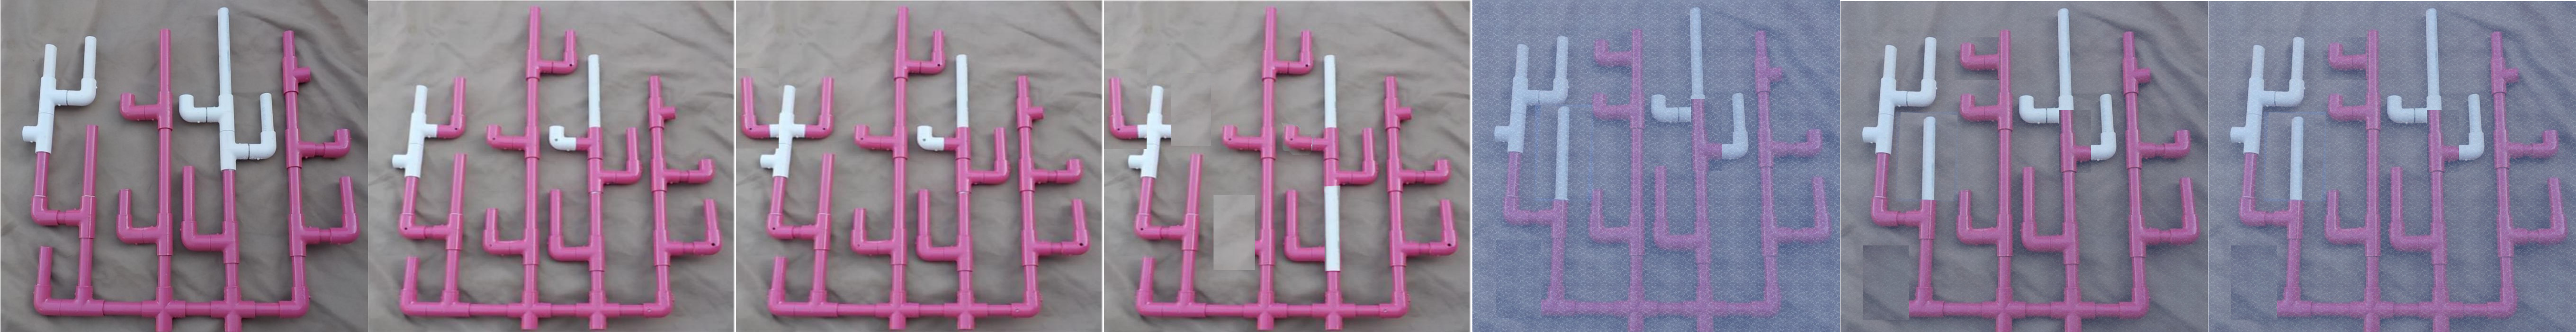

In [35]:
#@title Show the images
together = np.concatenate( (cv.imread(IMAGE_NAMES[0]), 
                            cv.imread(IMAGE_NAMES[1]),
                            cv.imread(IMAGE_NAMES[2]),
                            cv.imread(IMAGE_NAMES[3]),
                            cv.imread(IMAGE_NAMES[4]),
                            cv.imread(IMAGE_NAMES[5]),
                            cv.imread(IMAGE_NAMES[6])), axis=1)
cv2_imshow(together)

In [13]:
#@title PipeImage Class
class PipeImage:

  def __init__(self, file_name):
    self.orig_img = cv.imread(file_name)
    if self.orig_img is None:
      raise FileNotFoundError
    self.mod_img = np.copy(self.orig_img)
    self.aligned_img = None
    self.white_thresh = None
    self.pink_thresh = None
    self.contours = None

  """
  Function receives an image of a pipe and separates the pink pipes and
  the white pipes.
  The returned array will have 0 for black values and 255 for the color
  values
  """
  @staticmethod
  def default_thresh(img):
    orig_img = np.copy(img)

    #convert to grayscale
    orig_img_gray = cv.cvtColor(orig_img, cv.COLOR_BGR2GRAY)

    #Separate the white pipes out

    ret, white_pipe_thresh = cv.threshold(orig_img_gray, 180, 255, 0)

    frame_HSV = cv.cvtColor(orig_img, cv.COLOR_BGR2HSV)

    pink_pipe_thresh = cv.inRange(frame_HSV, (140, 60, 0), (175, 255, 255))

    return white_pipe_thresh, pink_pipe_thresh

  """
  apply the passed in thresholding function or
  the default one if one isnt passed in to threshold
  the image
  """
  def get_thresh(self, thresh_func=None):
    if not thresh_func:
      thresh_func = self.__class__.default_thresh
    self.white_thresh, self.pink_thresh = thresh_func(self.orig_img if self.aligned_img is None else self.aligned_img)
    self.mod_img = np.logical_or(self.white_thresh, self.pink_thresh).astype(int)
    return self.white_thresh, self.pink_thresh
  
  """
  align an image given a reference image
  used to align the pipes so that comparisons
  can be made

  from here: https://www.learnopencv.com/image-alignment-feature-based-using-opencv-c-python/
  """
  def align(self, reference):
    MAX_FEATURES = 500
    GOOD_MATCH_PERCENT = 1


    img_cpy = self.orig_img
    ref_cpy = reference

    img_cpy = self.orig_img
    ref_cpy = reference
    
    #detect ORB features for the two images
    orb = cv.ORB_create(MAX_FEATURES)
    keypoints1, descriptors1 = orb.detectAndCompute(img_cpy, None)
    keypoints2, descriptors2 = orb.detectAndCompute(ref_cpy, None)
    
    # Match features.
    matcher = cv.DescriptorMatcher_create(cv.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
    matches = matcher.match(descriptors1, descriptors2, None)
    
    # Sort matches by score
    matches.sort(key=lambda x: x.distance, reverse=False)

    # Remove not so good matches
    numGoodMatches = int(len(matches) * GOOD_MATCH_PERCENT)
    matches = matches[:numGoodMatches]

    #if (show_alignment):
      # Draw top matches
      #imMatches = cv.drawMatches(img_cpy, keypoints1, ref_cpy, keypoints2, matches, None)
      #cv2_imshow(imMatches)
    
    # Extract location of good matches
    points1 = np.zeros((len(matches), 2), dtype=np.float32)
    points2 = np.zeros((len(matches), 2), dtype=np.float32)

    for i, match in enumerate(matches):
      points1[i, :] = keypoints1[match.queryIdx].pt
      points2[i, :] = keypoints2[match.trainIdx].pt
    
    # Find homography
    h, mask = cv.findHomography(points1, points2, cv.RANSAC)

    # Use homography
    height, width, channels = reference.shape
    
    self.mod_img = self.aligned_img = cv.warpPerspective(img_cpy, h, (width, height))

    return self.aligned_img

  @staticmethod
  def joinimages(*args):
    return np.concatenate(args, axis=1)

  """
  Show the image and its thresholds
  """
  def show(self, show_orig=True, show_aligned=True, show_white_thresh=True, show_pink_thresh=True):
    to_be_shown = list()
    if show_orig: to_be_shown.append(self.orig_img)
    if show_aligned and self.aligned_img is not None: to_be_shown.append(self.aligned_img)
    if show_white_thresh: 
      to_be_shown.append(
          cv.cvtColor(self.white_thresh, cv.COLOR_GRAY2BGR)
          )
    if show_pink_thresh: 
      to_be_shown.append(
          cv.cvtColor(self.pink_thresh, cv.COLOR_GRAY2BGR)
          )
    cv2_imshow(PipeImage.joinimages(*tuple(to_be_shown)))

  


In [28]:
#@title PipeImgDiff Class

class PipeImgDiff():

  def __init__(self, before_img, after_img):
    self.white_orig = np.copy(before_img.white_thresh)
    self.pink_orig = np.copy(before_img.pink_thresh)
    self.white_after = np.copy(after_img.white_thresh)
    self.pink_after = np.copy(after_img.pink_thresh)
    self.output = np.copy(after_img.aligned_img)
    
    self.diff = None
    self.diff_contours = None
    self.growth = None
    self.death = None
    self.bleaching = None
    self.recovery = None

  def find_changes(self):
    self.growth = self.pink_after & ~(self.white_orig | self.pink_orig)
    self.growth[self.growth == 1] = 255

    self.death = (self.white_orig | self.pink_orig) & (~(self.white_after | self.pink_after))
    self.death[self.death == 1] = 255

    self.bleaching = self.pink_orig & self.white_after
    self.bleaching[self.bleaching == 1] = 255

    self.recovery = self.white_orig & self.pink_after
    self.recovery[self.recovery == 1] = 255

    
  def draw_changes(self):
    #set growth to green
    blocks = PipeImgDiff.block_threshold(self.growth, 30, 0.8).astype('uint8')
    contours, hierarchy = cv.findContours(blocks, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    cv.drawContours(self.output, contours, -1, (0,255,0), 6)

    # set death to yellow
    blocks = PipeImgDiff.block_threshold(self.death, 30, 0.8).astype('uint8')
    contours, hierarchy = cv.findContours(blocks, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    cv.drawContours(self.output, contours, -1, (0,255,255), 6)

    # set bleaching to red
    blocks = PipeImgDiff.block_threshold(self.bleaching, 30, 0.5).astype('uint8')
    contours, hierarchy = cv.findContours(blocks, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    cv.drawContours(self.output, contours, -1, (0,0,255), 6)

    #set recovery to blue
    blocks = PipeImgDiff.block_threshold(self.recovery, 30, 0.6).astype('uint8')
    contours, hierarchy = cv.findContours(blocks, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    cv.drawContours(self.output, contours, -1, (255,0,0), 6)

    cv2_imshow(self.output)
    

  '''
  Call after find_difference. Modifies self.diff
  by iterating through image by block chunks and changing entire
  chunks if the amount of white pixels does not meet the cutoff.
  T can be changed but really it should just be 255 always
  '''  
  @staticmethod
  def block_threshold(img, blocks, cutoff, T = 255):
    image = np.copy(img)

    h = image.shape[0]
    w = image.shape[1]
    bh = h/blocks #block_height
    bw = w/blocks #block_width
    block_size = bh * bw
    block_cutoff = block_size * cutoff
    white_blocks = []

    for y in range(blocks):
      for x in range(blocks):
        block_sum = np.sum(image[int(bh*y):int(bh*(y+1)),int(bw*x):int(bw*(x+1))])
        if (block_sum > block_cutoff * T):
          image[int(bh*y):int(bh*(y+1)),int(bw*x):int(bw*(x+1))] = T
          white_blocks.append((y,x))
        elif (block_sum >= 0):
          image[int(bh*y):int(bh*(y+1)),int(bw*x):int(bw*(x+1))] = 0
    

    for block in white_blocks:
      y = block[0]
      x = block[1]
      image[int(bh*((y-1) if y>0 else 0)):int(bh*((y+2) if y<blocks+1 else y+1)),int(bw*((x-1) if x>0 else 0)):int(bw*((x+2) if x<blocks+1 else x+1))] = T

    return image

    for y in range(blocks):
      for x in range(blocks):
        block_sum = np.sum(image[bh*y:bh*(y+1),bw*x:bw*(x+1)])
        if (block_sum > block_cutoff * T):
          image[bh*y:bh*(y+1),bw*x:bw*(x+1)] = T
          white_blocks.append((y,x))
        elif (block_sum >= 0):
          image[bh*y:bh*(y+1),bw*x:bw*(x+1)] = 0
    for block in white_blocks:
      y = block[0]
      x = block[1]
      image[bh*((y-1) if y>0 else 0):bh*((y+2) if y<blocks+1 else y+1),bw*((x-1) if x>0 else 0):bw*((x+2) if x<blocks+1 else x+1)] = T

    return image

  """
  get the contours from the difference
  """
  def get_contours(self, blocked = True, bounded=False, min_area=0):
    con_final = list()
    if blocked == True:
      diff = self.block_diff
    else:
      diff = self.diff
  
    #get contours from the image
    print(np.unique(diff, return_counts=True))
    contours, hierarchy = cv.findContours(diff, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    
    if min_area > 0:
      #filter the contours that are bigger in area than min_area
      con_final = [contour for contour in contours if cv.contourArea(contour) > min_area]
    else:
      con_final = contours

    if bounded:
      #make the contours rectangles
      for i in range(len(con_final)):
        box_contour = cv.boxPoints(cv.minAreaRect(con_final[i]))
        con_final[i] = np.int0(box_contour)
  
    self.diff_contours = con_final

    return self.diff_contours
  
  """
  Filter the contours on their area:perimeter ratio
  useful for filtering strips
  """
  def filter_contour(self, cutoff=0.1):
    processed =  list()
    for contour in self.diff_contours:
      area = cv.contourArea(contour)
      per = cv.arcLength(contour, True)

      if area > 0 and per/area < cutoff:
        processed.append(contour)
    
    self.diff_contours = processed
    return self.diff_contours

  def show_diff(self):
    cv2_imshow(PipeImage.joinimages(self.orig_img1, self.orig_img2, self.diff))

  def show_contours(self, orig_image):
    cv2_imshow(cv.drawContours(np.copy(orig_image), self.diff_contours, -1, (0,255,0), 3 ))

  def show(self, orig_image, after_image, blocked = True):
    #show the before/after threshs and draw the contours on orig_image
    if blocked == True:
      cv2_imshow(PipeImage.joinimages(
          cv.cvtColor(self.orig_img1, cv.COLOR_GRAY2BGR), 
          cv.cvtColor(self.orig_img2, cv.COLOR_GRAY2BGR), 
          cv.cvtColor(self.diff, cv.COLOR_GRAY2BGR),
          cv.cvtColor(self.block_diff, cv.COLOR_GRAY2BGR),
          after_image,
          cv.drawContours(np.copy(orig_image), self.diff_contours, -1, (0,255,0), 3 ) )
          )
    else:
      cv2_imshow(PipeImage.joinimages(
          cv.cvtColor(self.orig_img1, cv.COLOR_GRAY2BGR), 
          cv.cvtColor(self.orig_img2, cv.COLOR_GRAY2BGR), 
          cv.cvtColor(self.diff, cv.COLOR_GRAY2BGR),
          after_image,
          cv.drawContours(np.copy(orig_image), self.diff_contours, -1, (0,255,0), 3 ) )
          )

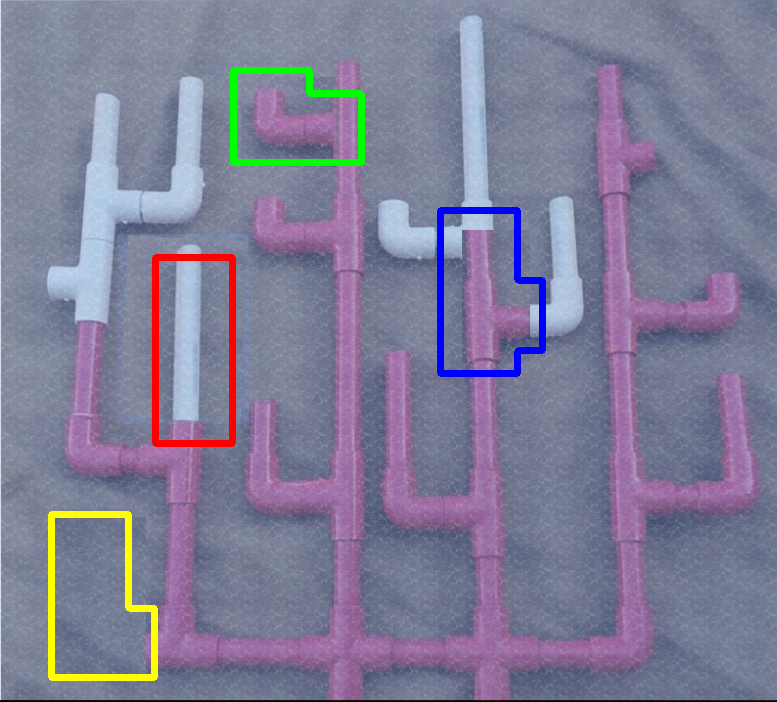

In [31]:
#Usage examples of the two classes

original_image = PipeImage("before.jpg")
after_image = PipeImage("after6.jpg")

#align the after image with the before
after_image.align(original_image.orig_img)

#use default threshing function
original_image.get_thresh()
after_image.get_thresh()

#shows the orginal image | aligned image | white pipe thresh | pink pipe thresh in that order
#original_image.show()
#after_image.show(show_orig=False) #just show the aligned one

all_diff = PipeImgDiff(original_image, after_image)
all_diff.find_changes()
all_diff.draw_changes()
